In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

from cod.train import train_model
from cod.split import train_test_split_for_direct_ty_file
from cod.tools import set_seed
from cod.Transform import get_transforms
from cod.Dataset import MyDataset
from cod.models import resnet18, MobileNetV2
from cod.tools import creat_snp_folder_path
from cod.tools import show_train

# Классификация пород кошек и собак по лицу

Используем упрощенный датасет [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) с вырезанными лицами домашних животных. Для начала загружаем датасет:

In [2]:
# from urllib import request
# import os
# import tarfile
# URL = "http://www.soshnikov.com/permanent/data/petfaces.tar.gz"
# response = request.urlretrieve("http://www.soshnikov.com/permanent/data/petfaces.tar.gz", "petfaces.tar.gz")
# file = tarfile.open('petfaces.tar.gz')
# file.extractall('./data')
# file.close()
# os.remove("petfaces.tar.gz")

## Константы

In [3]:
SIZE = 224
dirdata = "data/petfaces/"
train_files = "train.csv"
val_files = "val.csv"
batch_size = 53
num_workers = 4
seed = 100
N_class = 35
num_epochs=100
lr = 0.001

# Модель

In [4]:
set_seed(seed)
model = resnet18(N_class)

# Формирование структуры датасета

## Фиксация сида и разбиение набора данных

In [5]:
set_seed(seed)
train_test_split_for_direct_ty_file("data/petfaces")

## DataLoader

In [6]:
val_transforms, train_transforms = get_transforms(SIZE)
train_data = MyDataset(os.path.join(dirdata,train_files), dirdata, train_transforms)
val_data = MyDataset(os.path.join(dirdata,val_files), dirdata, val_transforms)
val_data_binary = MyDataset(os.path.join(dirdata,val_files), dirdata, val_transforms, is_doc_cat = True)
train_dataloader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, pin_memory=True, drop_last=True, shuffle=False, sampler=train_data.getSampler(name_clases = "multiclass"))
val_dataloader = DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, pin_memory=True, drop_last=True, shuffle=False)
val_dataloader_binary = DataLoader(val_data_binary, batch_size=batch_size, num_workers=num_workers, pin_memory=True, drop_last=True, shuffle=False)

## Визуализация данных

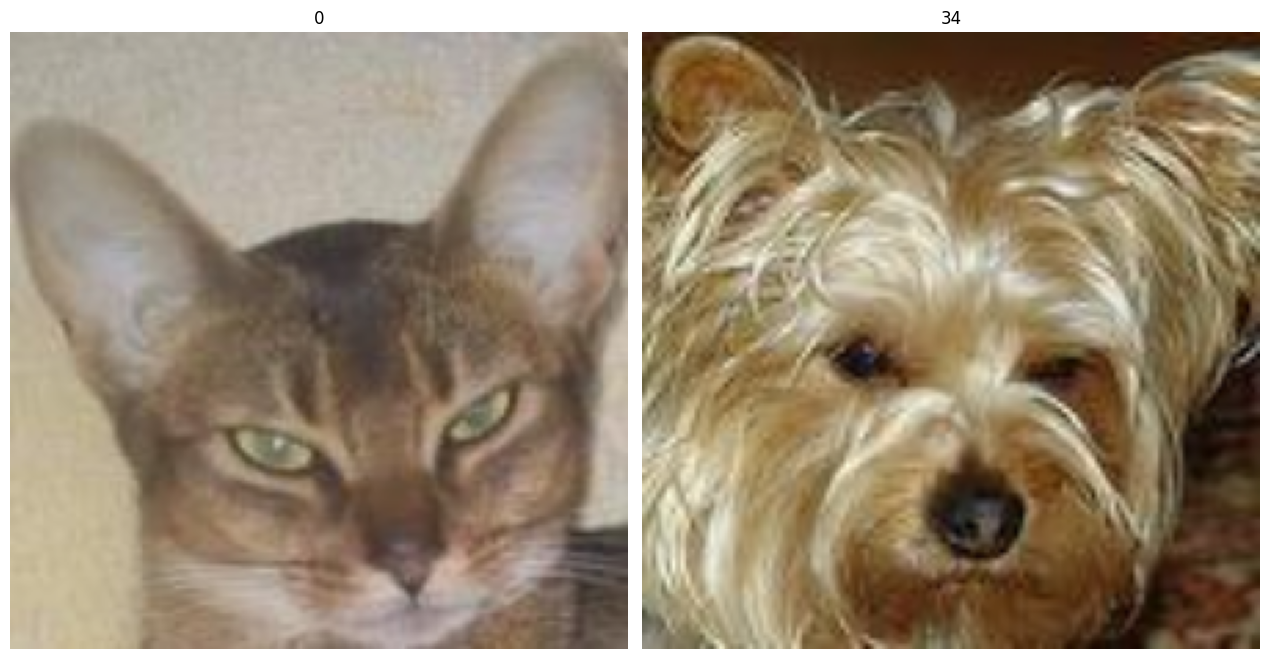

In [7]:
def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

image_cat, label_cat = val_data.__getitem__(1)
image_dog, label_dog  = val_data.__getitem__(635)

image_cat = image_cat.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_cat = std * image_cat + mean

image_dog = image_dog.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_dog = std * image_dog + mean

display_images([image_cat,image_dog], [label_cat, label_dog])

# Обучение

### Учим в 2 этапа: 
1) Холостой прогон модели для инициализации хороших стартовых весов
2) Основное обучение

### Задаём фазы обучения и валидации

In [8]:
dataloaders={'T':train_dataloader,
             'V':val_dataloader}
phases=['T','V']
top_k = {'T':1, 'V':1}
         

## 1 этап

### Задаём оптимизатор и отключаем шедулер

In [9]:
classification_criterion=torch.nn.CrossEntropyLoss()
optimizer_ft =optim.AdamW(model.parameters(), lr = lr)#betas=(momentum,momentumB),)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,step_size=100, gamma=1)

### Создание папки для результатов обучения

In [10]:
snp_path =creat_snp_folder_path(model_name = "resnet18",Dataset_name="petfaces_35")
print(snp_path)

snp/petfaces_35/resnet18/05_05_2023/15_38_35/


### Запуск 1 этапа обучения

In [ ]:
set_seed(seed)
_,best_model_the_acc_classification,_  =train_model(model,
            classification_criterion, 
            optimizer_ft, 
            dataloaders,
            exp_lr_scheduler,
            batch_size, 
            snp_path, 
            num_epochs,
            top_k)

### Визуализация хода обучения

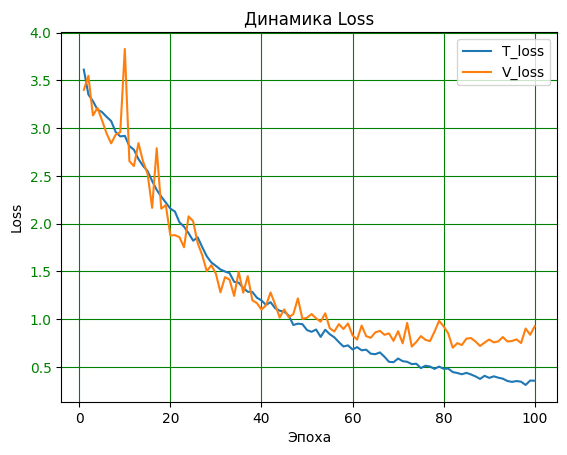

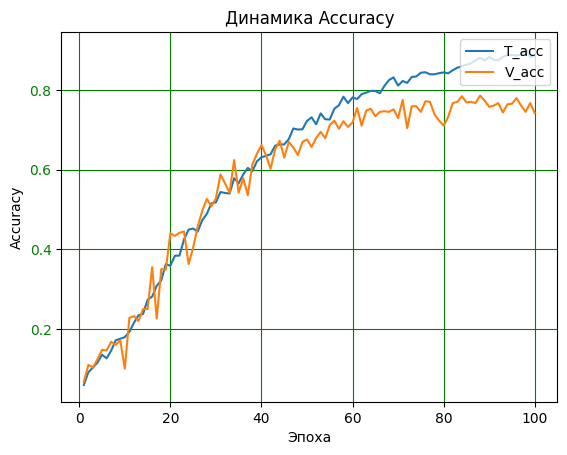

In [12]:
show_train(snp_path + "log.csv")

## 2 Этап

### Загрузка модели с 1 этапа и подключение label_smoothing и адаптивного шедулера

In [13]:
# weights = torch.load("snp/Dataset_name/model_name/24_04_2023/17_22_46/model_name_Dataset_name_91_CrossEntropyLoss-0.7231_checkpoint.tar", map_location='cpu')
# model.load_state_dict(weights['state_dict'], strict=True)
model.load_state_dict(best_model_the_acc_classification['V'], strict=True)
optimizer_ft =optim.AdamW(model.parameters(), lr = lr)
exp_lr_scheduler=lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'max',factor=0.75,patience=5)
classification_criterion=torch.nn.CrossEntropyLoss(label_smoothing=0.2)

### Создание папки для результатов обучения

In [14]:
snp_path =creat_snp_folder_path(model_name = "resnet18",Dataset_name="petfaces_35")
print(snp_path)

snp/petfaces_35/resnet18/05_05_2023/16_19_13/


### Запуск 2 этапа обучения

In [ ]:
set_seed(seed)
_,best_model_the_acc_classification,_ =train_model(model,
            classification_criterion, 
            optimizer_ft, 
            dataloaders,
            exp_lr_scheduler,
            batch_size, 
            snp_path, 
            num_epochs,
            top_k)

### Визуализация хода обучения

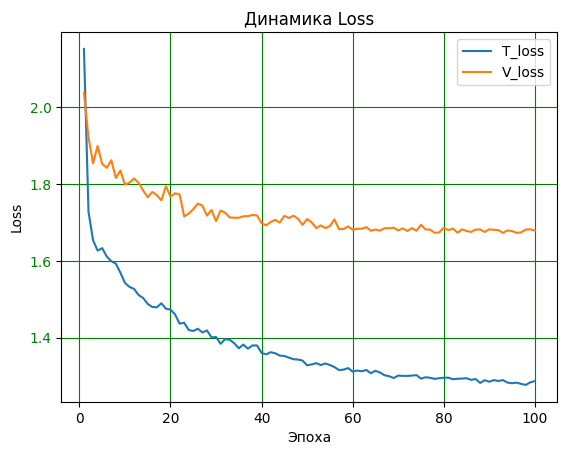

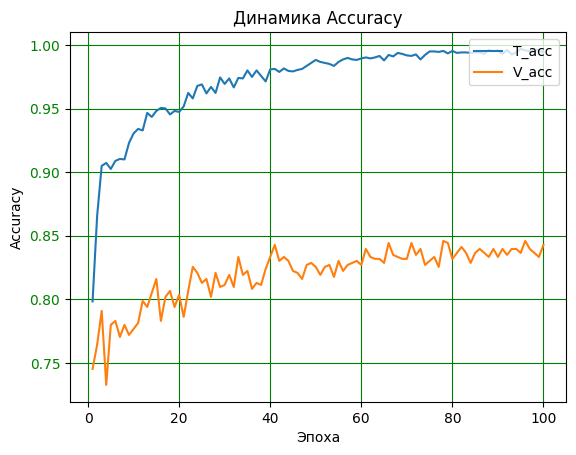

In [16]:
show_train(snp_path + "log.csv")

# Расчет качества модели

### Задаём оптимизатор и отключаем шедулер

In [17]:
classification_criterion=torch.nn.CrossEntropyLoss()
optimizer_ft =optim.AdamW(model.parameters(), lr = lr)#betas=(momentum,momentumB),)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,step_size=100, gamma=1)

### Загрузка обученной модели

In [18]:
model.load_state_dict(best_model_the_acc_classification['V'], strict=True)

<All keys matched successfully>

## Многоклассовая классификация

### Создание папки для результатов тестирования

In [19]:
snp_path =creat_snp_folder_path(model_name = "resnet18",Dataset_name="petfaces_35")
print(snp_path)

snp/petfaces_35/resnet18/05_05_2023/16_58_06/


### Формируем фазы валидации

In [20]:
dataloaders={'Top_1':val_dataloader,
             'Top_3':val_dataloader,
             'Top_5':val_dataloader}
phases=['Top_1','Top_3','Top_5']
top_k = {'Top_1':1,'Top_3':3,'Top_5':5}

### Запуск расчета статистики

In [21]:
_, _, _=train_model(model,
            classification_criterion, 
            optimizer_ft, 
            dataloaders,
            exp_lr_scheduler,
            batch_size, 
            snp_path, 
            1,
            top_k,
            phases)

Training complete in 0m 16s
Best Top_1 Loss: 0.9236, epoch 0  
Best Top_1 Acc : 0.8428, epoch 0
Best Top_3 Loss: 0.9236, epoch 0  
Best Top_3 Acc : 0.9340, epoch 0
Best Top_5 Loss: 0.9236, epoch 0  
Best Top_5 Acc : 0.9607, epoch 0
Epoch 1/1
----------
Top_1 Loss: 0.9236 Acc: 0.8428
Top_3 Loss: 0.9236 Acc: 0.9340
Top_5 Loss: 0.9236 Acc: 0.9607



```
Top_1 Loss: 0.9236 Acc: 0.8428
Top_3 Loss: 0.9236 Acc: 0.9340
Top_5 Loss: 0.9236 Acc: 0.9607

## Двухклассовая классификация

### Создание папки для результатов обучения

In [22]:
snp_path =creat_snp_folder_path(model_name = "resnet18",Dataset_name="petfaces_35")
print(snp_path)

snp/petfaces_35/resnet18/05_05_2023/16_58_22/


### Формируем фазы валидации

In [23]:
dataloaders={'Top_1':val_dataloader_binary}
phases=['Top_1']
top_k = {'Top_1':1}

### Запуск расчета статистики

In [24]:
model1, model2, overfit_model=train_model(model,
            classification_criterion, 
            optimizer_ft, 
            dataloaders,
            exp_lr_scheduler,
            batch_size, 
            snp_path, 
            1,
            top_k,
            phases)

Training complete in 0m 5s
Best Top_1 Loss: 0.4345, epoch 0  
Best Top_1 Acc : 0.9575, epoch 0
Epoch 1/1
----------
Top_1 Loss: 0.4345 Acc: 0.9575



```
Top_1 Loss: 0.4345 Acc: 0.9575

# Оптимизация сети

## Для ускорения на процессоре была подготовленны сеть архитектуры MobileNetV2

### Всё тоже самое что и выше

In [ ]:
set_seed(seed)
model = MobileNetV2(N_class)
dataloaders={'T':train_dataloader,
             'V':val_dataloader}
phases=['T','V']
top_k = {'T':1, 'V':1}
classification_criterion=torch.nn.CrossEntropyLoss()
optimizer_ft =optim.AdamW(model.parameters(), lr = lr)#betas=(momentum,momentumB),)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,step_size=100, gamma=1)
snp_path =creat_snp_folder_path(model_name = "MobileNetV2",Dataset_name="petfaces_35")
_,best_model_the_acc_classification,_  =train_model(model,
            classification_criterion, 
            optimizer_ft, 
            dataloaders,
            exp_lr_scheduler,
            batch_size, 
            snp_path, 
            num_epochs,
            top_k)
model.load_state_dict(best_model_the_acc_classification['V'], strict=True)
optimizer_ft =optim.AdamW(model.parameters(), lr = lr)
exp_lr_scheduler=lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'max',factor=0.75,patience=5)
classification_criterion=torch.nn.CrossEntropyLoss(label_smoothing=0.2)
snp_path =creat_snp_folder_path(model_name = "MobileNetV2",Dataset_name="petfaces_35")
_,best_model_the_acc_classification,_ =train_model(model,
            classification_criterion, 
            optimizer_ft, 
            dataloaders,
            exp_lr_scheduler,
            batch_size, 
            snp_path, 
            num_epochs,
            top_k)

In [31]:
model.load_state_dict(best_model_the_acc_classification['V'], strict=True)
dataloaders={'Top_1':val_dataloader,
             'Top_3':val_dataloader,
             'Top_5':val_dataloader,
             'Top_1_binary':val_dataloader_binary,
             }
phases=['Top_1','Top_3','Top_5','Top_1_binary']
top_k = {'Top_1':1,'Top_3':3,'Top_5':5,'Top_1_binary':1}
snp_path =creat_snp_folder_path(model_name = "MobileNetV2",Dataset_name="petfaces_35")
model1, model2, overfit_model=train_model(model,
            classification_criterion, 
            optimizer_ft, 
            dataloaders,
            exp_lr_scheduler,
            batch_size, 
            snp_path, 
            1,
            top_k,
            phases)

Training complete in 0m 21s
Best Top_1 Loss: 1.6535, epoch 0  
Best Top_1 Acc : 0.8302, epoch 0
Best Top_3 Loss: 1.6535, epoch 0  
Best Top_3 Acc : 0.9497, epoch 0
Best Top_5 Loss: 1.6535, epoch 0  
Best Top_5 Acc : 0.9686, epoch 0
Best Top_1_binary Loss: 0.4808, epoch 0  
Best Top_1_binary Acc : 0.9591, epoch 0
Epoch 1/1
----------
Top_1 Loss: 1.6535 Acc: 0.8302
Top_3 Loss: 1.6535 Acc: 0.9497
Top_5 Loss: 1.6535 Acc: 0.9686
Top_1_binary Loss: 0.4808 Acc: 0.9591



```
Top_1 Loss: 1.6535 Acc: 0.8302
Top_3 Loss: 1.6535 Acc: 0.9497
Top_5 Loss: 1.6535 Acc: 0.9686
Top_1_binary Loss: 0.4808 Acc: 0.9591

# confusion matrix

In [29]:
t = torch.load("snp\petfaces_35/resnet18/05_05_2023/16_19_13/78_V_ACC top1-0.8459_checkpoint.tar")['confusion_matrix'].numpy().astype(int)
confusion_matrix = pd.DataFrame(t)
pd.set_option("display.max_columns", 100)
confusion_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,8,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,17,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,13,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,3,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,1,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,24,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,1,0,0,1,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
